In [1262]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from graphviz import Digraph
import os
from IPython import display
import logging

In [1263]:
logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.ERROR, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

In [1264]:
# Required for Jupyter Notebook to find the graphviz executables
os.environ["PATH"] += os.pathsep + os.path.abspath("/opt/homebrew/bin/")

In [1265]:
# Sample function for gradient calculation
def f(x):
    return 3*x**2 - 4*x + 5

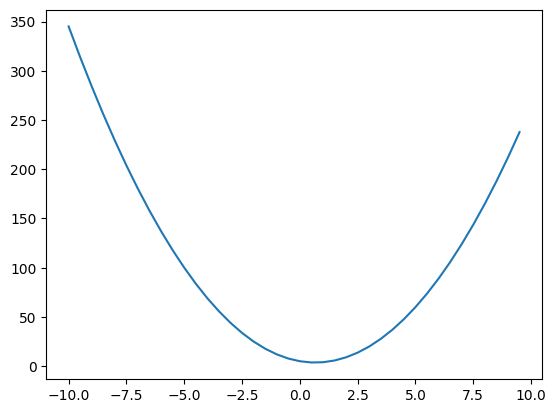

In [1266]:
xs = np.arange(-10, 10, 0.5)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [1267]:
h = 0.000001

In [1268]:
a = 3
b = -2
c = 1
d1 = a*b + c

In [1269]:
c = c + h
d2 = a*b + c

In [1270]:
print("d1 = ", d1)
print("d2 = ", d2)
print("dc_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dc_dy =  1.000000000139778


In [1271]:
a = 3; b = -2; c = 1
d1 = a*b + c
a = a + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("da_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -5.000002
da_dy =  -2.000000000279556


In [1272]:
a = 3; b = -2; c = 1
d1 = a*b + c
b = b + h
d2 = a*b + c
print("d1 = ", d1)
print("d2 = ", d2)
print("db_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.9999970000000005
db_dy =  2.9999999995311555


In [1273]:
a = 3; b = -2; c = 1
d1 = a*b + c
d2 = a*b + h + c
print("d1 = ", d1)
print("d2 = ", d2)
print("dab_dy = ", (d2 - d1) / h)

d1 =  -5
d2 =  -4.999999
dab_dy =  1.000000000139778


In [1274]:
class Value():
    """ Basic class to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if isinstance(other, Value):
            return Value(self.data + other.data, _children=(self, other), _op='+')
        else:
            raise ValueError("Can only add Value to Value")
    
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [1275]:
a = Value(3, label="a")
b = Value(-2, label="b")
c = Value(1, label="c")
d = a*b + c; d.label = "d"
print(f"d._prev = {d._prev} d = {d.data}")

d._prev = (Value(data=-6), Value(data=1)) d = -5


In [1278]:
def draw_graph(root):
    """ Vibe codded and it works! """
    # Initialize a directed graph
    dot = Digraph(format='png', graph_attr={'rankdir': 'LR'})  # Left-to-right layout
    
    def build_graph(node, visited=None):
        if visited is None:
            visited = set()
        
        # Skip if node already visited to avoid cycles
        if id(node) in visited:
            return
        visited.add(id(node))
        
        # Add node to the graph
        node_id = str(id(node))
        dot.node(node_id, f"{{ {node.label} | data = {node.data} grad={node.grad} }}", shape='record')
        
        # If node has an operation, create an operation node
        if node._op:
            op_id = f"{node_id}_op"
            dot.node(op_id, node._op, shape='circle')
            dot.edge(op_id, node_id)  # Edge from operation to result
        
            # Recursively process children
            for child in node._prev:
                child_id = str(id(child))
                build_graph(child, visited)
                dot.edge(child_id, op_id)  # Edge from child to operation
    
    # Build the graph starting from the root
    build_graph(root)
    
    # Render and display the graph
    dot.render('computation_graph', view=True, cleanup=True)
    
    return dot


In [1279]:
# draw_graph(d)

In [1280]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

In [1281]:
print(f"o = {o.data}")

o = -0.9866142981514304


In [1284]:
# draw_graph(o)

In [1285]:
# Backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

In [1286]:
# draw_graph(o)

In [1287]:
do_dn = 1 - math.tanh(o.data)**2
y.grad = do_dn

In [1288]:
# draw_graph(o)

In [1289]:
x1w1_x2w2.grad = y.grad
b.grad = y.grad
x1w1.grad = x1w1_x2w2.grad
x2w2.grad = x1w1_x2w2.grad

# draw_graph(o)

In [1290]:
x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

# draw_graph(o)

In [1300]:
# Implement generic backpropagation
class Value():
    """ Complete class with backprop to represent a scale value with arithmeti operations and gradients. """
    def __init__(self, data, _children=(), _op = '', grad=0.0, label=""):
        self.data = data
        self._prev = _children
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient initialized to zero

    def backward(self, root_node, visited=None):
        visited.add(self)
        logger.debug(f"node.data = {self.data}")
        self._backward()  # Compute the gradient for childeren of this node
        for item in self._prev:
            if item not in visited:
                item.backward(root_node, visited)

    def _backward(self):
        """ Perform backpropagation to compute gradients. """
        logger.debug(f"Backward pass for node: {self.label}, op: {self._op}, data: {self.data}, grad: {self.grad}")
        # For addition operation, local gradient is 1 for each child hence gradient of the child with respect
        # to the output is 1 * self gradient.
        # Note, we need to accumulate gradients for each child and not simply overwrite them.
        if self._op == '+':
            for child in self._prev:
                child.grad += self.grad

        # For multiplication operation, local gradient is the value of the other child hence
        # gradient of the child with respect to the output is self.grad * other child's value.
        elif self._op == '*':
            self._prev[0].grad = self.grad * self._prev[1].data
            self._prev[1].grad = self.grad * self._prev[0].data

        elif self._op == '/':
            # For division operation, local gradient is 1 / other child's value hence
            # gradient of the child with respect to the output is self.grad * (1 / other child's value).
            self._prev[0].grad = self.grad / self._prev[1].data
            self._prev[1].grad = -self.grad * (self._prev[0].data / (self._prev[1].data ** 2))

        # For power operation, local gradient is power * base^(power-1) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == '**':
            power = self._prev[0].data
            base = self.data
            self._prev[0].grad = self.grad * power * (base ** (power - 1))

        # For subtraction operation, local gradient is 1 for the first child and -1 for the second child
        # hence gradient of the first child with respect to the output is self.grad * 1 and for the second child
        # it is self.grad * -1.
        elif self._op == '-':
            self._prev[0].grad = self.grad  # First child
            self._prev[1].grad = -self.grad  # Second child

        # For tanh operation, local gradient is 1 - tanh^2(self.data) hence
        # gradient of the child with respect to the output is self.grad * local gradient.
        elif self._op == 'tanh':
            logger.debug(f"tanh: self.data = {self.data}, self.grad = {self.grad}")
            self._prev[0].grad = self.grad * (1 - np.tanh(self._prev[0].data)**2)

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')

    def __radd__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data + other.data, _children=(self, other), _op='+')
    
    def __sub__(self, other):
        if isinstance(other, Value):
            return Value(self.data - other.data, _children=(self, other), _op='-')
        else:
            raise ValueError("Can only subtract Value from Value")
        
    def __mul__(self, other):
        if isinstance(other, Value):
            return Value(self.data * other.data, _children=(self, other), _op='*')
        else:
            raise ValueError("Can only multiply Value to Value")
        
    def __truediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')

    def __rtruediv__(self, other):
        if not isinstance(other, Value):
            other = Value(other)  # Convert to Value if not already
        return Value(self.data / other.data, _children=(self, other), _op='/')
        
    def __pow__(self, power):
        return Value(self.data ** power, _children=(self,), _op='**')
        
    def tanh(self):
        return Value((np.exp(self.data*2) - 1)/(np.exp(self.data*2) + 1), _op='tanh', _children=(self,))

In [1301]:
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

x1 = Value(2, label="x1")
x2 = Value(3, label="x2")
w1 = Value(0.5, label="w1")
w2 = Value(-1.5, label="w2")
b = Value(1, label="b")
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1_x2w2 = x1w1 + x2w2; x1w1_x2w2.label = "x1w1_x2w2"
y = x1w1_x2w2 + b; y.label = "y"
o = y.tanh(); o.label = "o"

python(19855) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


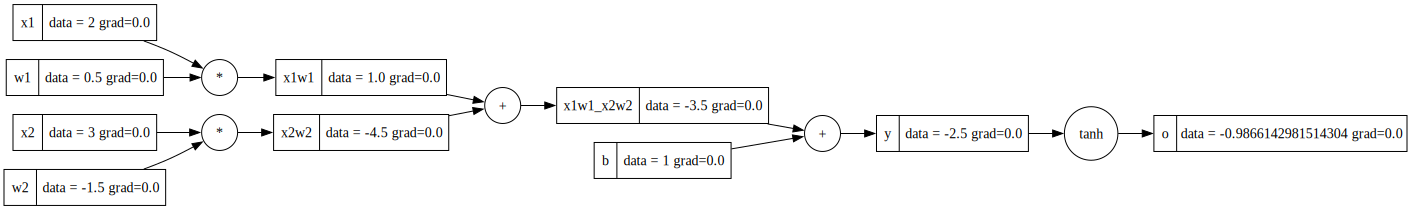

In [1302]:
draw_graph(o)

In [1303]:
# Perform backpropagation
o.grad = 1.0  # Set the gradient of the output to 1.0

visited = set()
o.backward(o, visited)

python(19903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19904) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19905) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


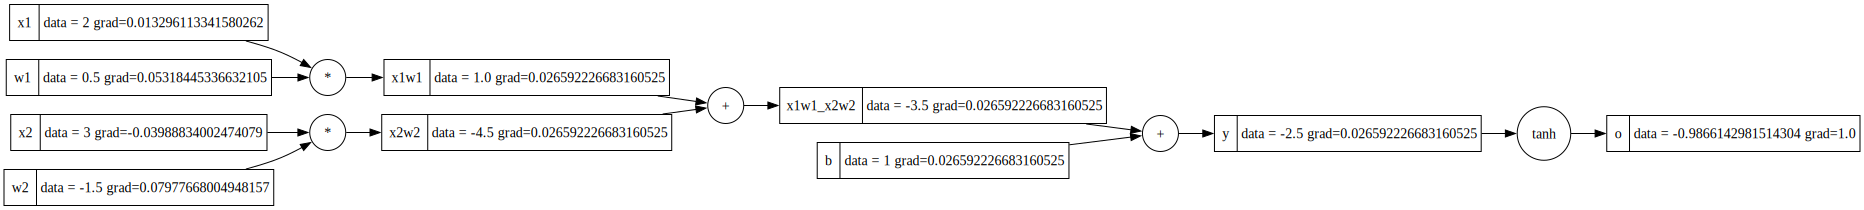

In [1304]:
draw_graph(o)

In [1305]:
# Verfiy with PyTorch
# Forward pass for neural network with one neuron
# Inputs: x1, x2; Weights: w1, w2; Bias: b; Output: y

import torch

x1 = torch.Tensor([2.0])
x2 = torch.Tensor([3.0])
w1 = torch.Tensor([0.5])
w2 = torch.Tensor([-1.5])
b = torch.Tensor([1.0])
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

y = x1 * w1 + x2 * w2 + b
o = torch.tanh(y)

print(f"o = {o.item()}")

o.backward()  # Perform backpropagation

o = -0.9866142868995667


In [1306]:
print(f"x1.grad = {x1.grad.item()}") 
print(f"x2.grad = {x2.grad.item()}") 
print(f"w1.grad = {w1.grad.item()}")
print(f"w2.grad = {w2.grad.item()}")
print(f"b.grad = {b.grad.item()}")

x1.grad = 0.013296124525368214
x2.grad = -0.039888374507427216
w1.grad = 0.053184498101472855
w2.grad = 0.07977674901485443
b.grad = 0.026592249050736427


In [1514]:
import random
random.seed(42)  # For reproducibility

class N():
    """ Class to represent a single neuron with forward and backward pass. """
    def __init__(self, input_size):
        self.input_size = input_size
        self.weights = [Value(random.uniform(-1, 1)) for _ in range(input_size)]
        self.b = Value(random.uniform(-1, 1))  # Bias term
    
    def parameters(self):
        return self.weights + [self.b]  # Return all parameters (weights and bias)
    
    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def __call__(self, input, act_fn=None) -> Value:
        """ Forward pass for the neuron. """
        assert len(input) == self.input_size, f"Input size {len(input)} does not match expected size {self.input_size}"
        wx = [w*x for w, x in zip(self.weights, input)]
        wx_sum = Value(0.0)  # Initialize sum of weighted inputs
        for item in wx:
            wx_sum += item  # Sum the weighted inputs

        wx_sum = wx_sum + self.b
        if act_fn is None:
            return wx_sum
        elif act_fn == 'tanh':
            return wx_sum.tanh()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")

In [1515]:
n = N(2)  # Create a neuron with 2 inputs
x1 = Value(2, label="x1")
x2 = Value(3, label="x2")

o = n([x1, x2])
print(f"o = {o.data}")

o = -2.742169638094225


In [1517]:
class Layer():
    """ Class to represent a layer of neurons. """
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.neurons = [N(input) for _ in range(output)]
    
    def parameters(self):
        parameters = []
        for n in self.neurons:
            parameters.extend(n.parameters())  # Collect parameters from each neuron
        return parameters
            
    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def __call__(self, input, act_fn=None):
        """ Forward pass for the layer. """
        outputs = [n(input, act_fn) for n in self.neurons]
        return outputs

In [1599]:
from typing import Callable

class NN():
    """ Class to represent a simple neural network with hidden layers. """
    def __init__(self, input_size: int, 
                 hidden_layer_num: int, 
                 hidden_layer_size: int, 
                 output_size: int):
        self.input_size = input_size
        self.hidden_layer_num = hidden_layer_num
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        self.forward_hook = None  # Hook for forward pass

        self.layers = []
        for i in range(hidden_layer_num):
            if i == 0:
                # First layer takes the input size
                self.layers.append(Layer(input_size, hidden_layer_size))
            elif i == hidden_layer_num - 1:
                # Last layer is the output layer, use output_size
                self.layers.append(Layer(hidden_layer_size, output_size))
            else:
                # Intermediate layers use hidden_layer_size
                self.layers.append(Layer(hidden_layer_size, hidden_layer_size))
           
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())  # Collect parameters from each layer
        return parameters

    def zero_grad(self):
        """ Reset gradients of all parameters to zero. """
        for param in self.parameters():
            param.grad = 0.0
            
    def register_forward_hook(self, func: Callable[[str, list[Value], list[Value]], None]): 
        self.forward_hook = func

    def __call__(self, input):
        """ Forward pass for the neural network. """
        assert len(input) == self.input_size, "input size mismatch"

        x = [Value(i) for i in input]
        for num, layer in enumerate(self.layers):
            if num != len(self.layers) - 1:
                act_fn = 'tanh'
            else:
                act_fn = None
            input = x.copy()
            x = layer(x, act_fn)  # Forward pass through the layer
            self.forward_hook(f"Layer {num}", [i.data for i in input], [o.data for o in x]) if self.forward_hook else None

        return x

In [1600]:
random.seed(42)  # For reproducibility
mlp = NN(input_size=3, hidden_layer_num=3, hidden_layer_size=4, output_size=1)  # Create a neural network with 2 inputs, 2 hidden layers of size 3, and 1 output 

In [1601]:
print("model information:")
print(f"input size: {mlp.input_size}")
print(f"total model layers: {len(mlp.layers)}")
for i, layer in enumerate(mlp.layers):
    print(f"[{i}] layer input: {layer.input}, layer output: {layer.output}, neurons: {len(layer.neurons)}")
print(f"total model parameters: {len(mlp.parameters())}")

# Build tensor parameters for the model, this will be used to set the parameters in PyTorch
mlp_tensor_parameters = []
print("model parameters:")
for layer_num, layer in enumerate(mlp.layers):
    layer_params = []
    bias_params = []
    for neuron_num, neuron in enumerate(layer.neurons):
        layer_params.append([x.data for x in neuron.parameters()][:-1])
        bias_params.append([x.data for x in neuron.parameters()][-1])
    mlp_tensor_parameters.append(torch.tensor(layer_params))
    mlp_tensor_parameters.append(torch.tensor(bias_params))
    
print(mlp_tensor_parameters)

model information:
input size: 3
total model layers: 3
[0] layer input: 3, layer output: 4, neurons: 4
[1] layer input: 4, layer output: 4, neurons: 4
[2] layer input: 4, layer output: 1, neurons: 1
total model parameters: 41
model parameters:
[tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]), tensor([-0.5536, -0.8261,  0.0107,  0.0899]), tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]]), tensor([ 0.6116, -0.3268,  0.6143,  0.1041]), tensor([[0.6588, 0.2370, 0.7234, 0.1547]]), tensor([0.4091])]


In [1602]:
# Create a PyTorch model with the same architecture for verification
import torch.nn as nn
torch.manual_seed(42)  # For reproducibility

class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 4),  # First hidden layer
            nn.Tanh(),
            nn.Linear(4, 4),  # Second hidden layer
            nn.Tanh(),
            nn.Linear(4, 1)   # Output layer
        )
    def forward(self, x):
        return self.layers(x)

def hook_fn(module, input, output, name=None):
    """ Hook function to capture the output of each layer. """
    print(f"Layer: {module}, Input: {input}, Output: {output}")

def rmse(y_true, y_pred):
    """ Calculate Root Mean Squared Error. """
    return torch.mean((y_true - y_pred) ** 2)

In [1603]:
tmlp = MLP(input_size=3)  # Create a PyTorch model with the same architecture
torch.manual_seed(42)  # For reproducibility
with torch.no_grad():
    for param_tmlp, param_mlp in zip(tmlp.parameters(), mlp_tensor_parameters):
        param_tmlp.copy_(param_mlp)

# Register hooks to capture the output of each layer
for name, module in tmlp.named_modules():
    print(f"Registering hook for layer: {name}")
    module.register_forward_hook(hook_fn)

print(f"model parameters = {[p for p in tmlp.parameters()]}")

Registering hook for layer: 
Registering hook for layer: layers
Registering hook for layer: layers.0
Registering hook for layer: layers.1
Registering hook for layer: layers.2
Registering hook for layer: layers.3
Registering hook for layer: layers.4
model parameters = [Parameter containing:
tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]], requires_grad=True), Parameter containing:
tensor([-0.5536, -0.8261,  0.0107,  0.0899], requires_grad=True), Parameter containing:
tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]], requires_grad=True), Parameter containing:
tensor([ 0.6116, -0.3268,  0.6143,  0.1041], requires_grad=True), Parameter containing:
tensor([[0.6588, 0.2370, 0.7234, 0.1547]], requires_grad=True), Parameter containing:
tensor([0.4091], requires_g

In [1605]:
# Print parameters of the PyTorch model
print("PyTorch model parameters:")
for name, param in tmlp.named_parameters():
    print(f"{name}: data: {param.data} grad={param.grad}")

PyTorch model parameters:
layers.0.weight: data: tensor([[ 0.2789, -0.9500, -0.4499],
        [ 0.4729,  0.3534,  0.7844],
        [-0.1562, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]) grad=None
layers.0.bias: data: tensor([-0.5536, -0.8261,  0.0107,  0.0899]) grad=None
layers.2.weight: data: tensor([[-0.5591,  0.1785,  0.6189, -0.9870],
        [ 0.3963, -0.3195, -0.6890,  0.9144],
        [-0.8145, -0.8066,  0.6950,  0.2075],
        [ 0.4595,  0.0725,  0.9462, -0.2429]]) grad=None
layers.2.bias: data: tensor([ 0.6116, -0.3268,  0.6143,  0.1041]) grad=None
layers.4.weight: data: tensor([[0.6588, 0.2370, 0.7234, 0.1547]]) grad=None
layers.4.bias: data: tensor([0.4091]) grad=None


In [1606]:
x = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]  # Example labels

In [1607]:
def loss_fn_mse(y_preds, y_true):
    """Mean squared error loss function."""
    loss = sum([(i - j)**2 for i, j in zip(y_preds, y_true)])

    return loss/len(y_preds)

In [1608]:
def loss_fn_mae(y_preds, y_true):
    """Mean absolute error loss function."""
    loss = sum([(i - j) for i, j in zip(y_preds, y_true)])

    return loss / len(y_preds)

In [1616]:
# First forward pass with our model
mlp.register_forward_hook(hook_fn)  # Register the hook to capture outputs
y_preds = mlp(x[0])
print(f"y_preds = {y_preds[0].data}")
print(f"y = {y[0]}")
loss = loss_fn_mse([y_preds[0]], [Value(y[0])])
print(f"loss = {loss}")

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.9835516902524112, 0.3786647677864891, -0.9881146621761316, -0.9991982757903943]
Layer: Layer 1, Input: [-0.9835516902524112, 0.3786647677864891, -0.9881146621761316, -0.9991982757903943], Output: [0.9230153224441545, -0.7878449485179578, 0.24680950547766523, -0.7654749814179418]
Layer: Layer 2, Input: [0.9230153224441545, -0.7878449485179578, 0.24680950547766523, -0.7654749814179418], Output: [0.930450953168436]
y_preds = 0.930450953168436
y = 1.0
loss = Value(data=0.004837069915179088)


In [1610]:
# First forward pass with PyTorch model
y_preds_tmlp = tmlp(torch.tensor(x[0]))
print(f"y_preds_tmlp = {y_preds_tmlp.item()}")
loss_tmlp = loss_fn_mse([Value(y_preds_tmlp.item())], [Value(y[0])])
print(f"loss_tmlp = {loss_tmlp}")

Layer: Linear(in_features=3, out_features=4, bias=True), Input: (tensor([ 2.,  3., -1.]),), Output: tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>),), Output: tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=4, bias=True), Input: (tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>),), Output: tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>),), Output: tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=1, bias=True), Input: (tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>),), Output: tensor([0.8661], grad_fn=<ViewBackward0>)
Layer: Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (

In [1617]:
# Backward pass with our model
mlp.zero_grad()
visited = set()
loss.grad = 1.0  # Set the gradient of the loss to 1.0
loss.backward(loss, visited)

In [1618]:
# Update parameters with gradients for our model
learning_rate = 0.001
for param in mlp.parameters():
    param.data -= learning_rate * param.grad

In [1613]:
# Backward pass with PyTorch model
import torch.optim as optim

optimizer = optim.SGD(tmlp.parameters(), lr=learning_rate)  # Create an optimizer
tmlp.train
optimizer.zero_grad()
output = tmlp(torch.tensor(x[0]))  # Forward pass
loss_rmse = rmse(torch.tensor([y[0]]), output)  # Calculate loss
loss_rmse.backward()  # Perform backpropagation

Layer: Linear(in_features=3, out_features=4, bias=True), Input: (tensor([ 2.,  3., -1.]),), Output: tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([-2.3959,  0.3956, -2.5601, -3.9107], grad_fn=<ViewBackward0>),), Output: tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=4, bias=True), Input: (tensor([-0.9835,  0.3762, -0.9881, -0.9992], grad_fn=<TanhBackward0>),), Output: tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>)
Layer: Tanh(), Input: (tensor([ 1.6034, -1.0696,  0.2179, -1.0128], grad_fn=<ViewBackward0>),), Output: tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>)
Layer: Linear(in_features=4, out_features=1, bias=True), Input: (tensor([ 0.9222, -0.7893,  0.2145, -0.7669], grad_fn=<TanhBackward0>),), Output: tensor([0.8661], grad_fn=<ViewBackward0>)
Layer: Sequential(
  (0): Linear(in_features=3, out_features=4, bias=True)
  (

In [1614]:
# Update parameters with gradients for PyTorch model
optimizer.step()  # Update parameters

In [1619]:
# Print updated parameters for out model
print("Updated parameters for our model:")
for param in mlp.parameters():
    print(f"{param.label}: {param.data} (grad: {param.grad})")

Updated parameters for our model:
: 0.27873192499369126 (grad: 0.0756247110604745)
: -0.9501609974377805 (grad: 0.11343706659071175)
: -0.44988052730072337 (grad: -0.03781235553023725)
: -0.5536393596633926 (grad: 0.03781235553023725)
: 0.4739633373446741 (grad: -0.6342846571410186)
: 0.3549303383707966 (grad: -0.9514269857115278)
: 0.7838486809013662 (grad: 0.3171423285705093)
: -0.825611880232843 (grad: -0.3171423285705093)
: -0.1560591252932449 (grad: -0.06036745919098969)
: -0.9402597081195379 (grad: -0.09055118878648453)
: -0.5627726680609004 (grad: 0.030183729595494844)
: 0.010759193874831895 (grad: -0.030183729595494844)
: -0.9469386036517635 (grad: 0.0065521775779216)
: -0.6023405131559391 (grad: 0.0098282663668824)
: 0.2997741470687918 (grad: -0.0032760887889608)
: 0.089877689696688 (grad: 0.0032760887889608)
: -0.5623934975652981 (grad: 2.0342276950948213)
: 0.17978900367177295 (grad: -0.7831722169988281)
: 0.6155709567439014 (grad: 2.0436650474487075)
: -0.9903293320791834 (

In [1598]:
# Print updated parameters of PyTorch model
print("Updated parameters for PyTorch model:")
for name, param in tmlp.named_parameters():
    print(f"{name}: {param.data} (grad: {param.grad})")

Updated parameters for PyTorch model:
layers.0.weight: tensor([[ 0.2788, -0.9500, -0.4499],
        [ 0.4727,  0.3530,  0.7845],
        [-0.1561, -0.9404, -0.5627],
        [-0.9469, -0.6023,  0.2998]]) (grad: tensor([[ 9.6584e-03,  1.4488e-02, -4.8292e-03],
        [ 2.5877e-01,  3.8816e-01, -1.2939e-01],
        [-6.8197e-03, -1.0229e-02,  3.4098e-03],
        [-9.6238e-05, -1.4436e-04,  4.8119e-05]]))
layers.0.bias: tensor([-0.5536, -0.8263,  0.0107,  0.0899]) (grad: tensor([ 4.8292e-03,  1.2939e-01, -3.4098e-03, -4.8119e-05]))
layers.2.weight: tensor([[-0.5591,  0.1785,  0.6188, -0.9870],
        [ 0.3963, -0.3195, -0.6891,  0.9144],
        [-0.8147, -0.8065,  0.6948,  0.2073],
        [ 0.4594,  0.0725,  0.9462, -0.2429]]) (grad: tensor([[ 0.0259, -0.0099,  0.0261,  0.0264],
        [ 0.0235, -0.0090,  0.0236,  0.0239],
        [ 0.1817, -0.0695,  0.1826,  0.1846],
        [ 0.0168, -0.0064,  0.0169,  0.0170]]))
layers.2.bias: tensor([ 0.6117, -0.3268,  0.6144,  0.1041]) (grad: 

In [1555]:
# Second forward pass with our model
y_preds = mlp(x[0])
print(f"y_preds = {y_preds[0].data}")
print(f"y = {y[0]}")
loss = loss_fn_mse([y_preds[0]], [Value(y[0])])
print(f"loss = {loss}")

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.9837086880999435, 0.4104862500252361, -0.9880359995850213, -0.9991988033317043]
Layer: Layer 1, Input: [-0.9837086880999435, 0.4104862500252361, -0.9880359995850213, -0.9991988033317043], Output: [0.9300756159974627, -0.7781620501975345, 0.4325779256190116, -0.7567228577133508]
Layer: Layer 2, Input: [0.9300756159974627, -0.7781620501975345, 0.4325779256190116, -0.7567228577133508], Output: [1.218553099743485]
y_preds = 1.218553099743485
y = 1.0
loss = Value(data=0.047765457407485716)


In [1556]:
for param in mlp.parameters():
    print(f"{param.label} = {param.data}, grad = {param.grad}")

 = 0.2781168415395158, grad = 0.73675537625166
 = -0.95101455180252, grad = 1.0360622478538968
 = -0.4496190327846514, grad = -0.32233047711010127
 = -0.5538548069684489, grad = 0.27628326609437254
 = 0.47874179372064934, grad = -5.7993653926245345
 = 0.361518086395497, grad = -8.119111549674347
 = 0.7818460770728869, grad = 2.5130583368039647
 = -0.8239959007638721, grad = -2.126433977295662
 = -0.15564021035113365, grad = -0.5161502783255044
 = -0.939686637521906, grad = -0.7189236019533811
 = -0.5629452576549328, grad = 0.22120726213950187
 = 0.010894915591841027, grad = -0.18433938511625153
 = -0.9469799415771389, grad = 0.05188094486624031
 = -0.6023965337811332, grad = 0.07183515443017889
 = 0.29979082518956673, grad = -0.021949630520332438
 = 0.08986500241782581, grad = 0.017958788607544723
 = -0.5740049233377658, grad = 14.886167419159179
 = 0.1837504684843409, grad = -5.219100732523457
 = 0.6063979977126209, grad = 12.46291564303239
 = -0.998344845293084, grad = 11.34236464920

In [1620]:
# Run model training for multiple epochs
epochs = 100
learning_rate = 0.01

# Reset model parameters
for param in mlp.parameters():
    param.data = random.uniform(-1, 1)  # Random initialization of parameters
    param.grad = 0.0

losses = []
accuracy = []
y_true = [Value(y_i) for y_i in y]  # Convert labels to Value objects

for epoch in range(epochs):
    y_preds = [mlp(i)[0] for i in x]  # Forward pass through the neural network
    loss = loss_fn_mse(y_preds, y_true)
    losses.append(loss)
    accuracy.append(1 - sum([abs(y_true - y_pred.data) for y_true, y_pred in zip(y, y_preds)]))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.data}, Accuracy: {accuracy[-1]}")
        
    mlp.zero_grad()  # Reset gradients of all parameters
    loss.grad = 1.0  # Set the gradient of the loss to 1.0
    visited = set()
    loss.backward(loss, visited)
    for param in mlp.parameters():
        param.data = param.data - learning_rate * param.grad  # Update parameters using gradient descent

Layer: Layer 0, Input: [2.0, 3.0, -1.0], Output: [-0.9991276315321914, -0.9918175594997916, -0.8350656162904463, 0.9423739739343306]
Layer: Layer 1, Input: [-0.9991276315321914, -0.9918175594997916, -0.8350656162904463, 0.9423739739343306], Output: [0.9237175099716631, -0.7910865084461395, 0.9660906038665381, -0.011681945501092817]
Layer: Layer 2, Input: [0.9237175099716631, -0.7910865084461395, 0.9660906038665381, -0.011681945501092817], Output: [-0.6695304217747466]
Layer: Layer 0, Input: [3.0, -1.0, 0.5], Output: [-0.996886996296201, -0.6386645378500293, -0.8637446594463088, 0.944183622989383]
Layer: Layer 1, Input: [-0.996886996296201, -0.6386645378500293, -0.8637446594463088, 0.944183622989383], Output: [0.8822340059944829, -0.7453213735062068, 0.957075979802214, -0.14906437136899842]
Layer: Layer 2, Input: [0.8822340059944829, -0.7453213735062068, 0.957075979802214, -0.14906437136899842], Output: [-0.6999307556674828]
Layer: Layer 0, Input: [0.5, 1.0, 1.0], Output: [-0.9784573575

In [1621]:
print(f"y_preds after training: {[item.data for item in y_preds]}")
print(f"y_true after training: {[item.data for item in y_true]}")

y_preds after training: [0.9007226665328086, 0.8340150728884494, 0.9254961936190139, 0.8310586725095291]
y_true after training: [1.0, -1.0, -1.0, 1.0]


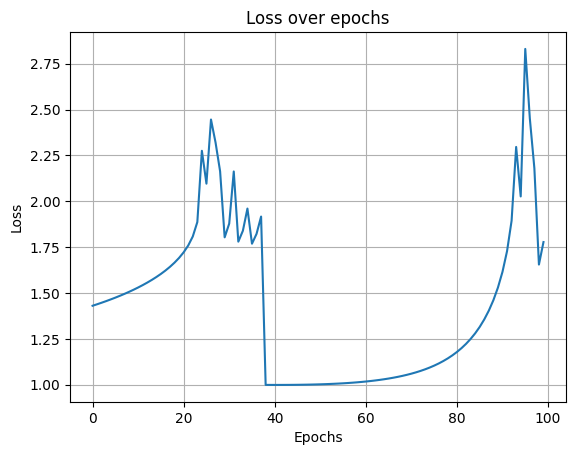

In [1622]:
# Plot the loss over epochs

plt.plot(range(epochs), [item.data for item in losses])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.grid()
plt.show()

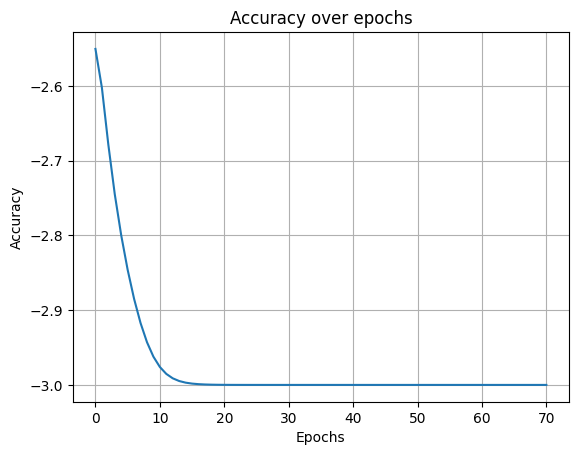

In [1249]:
# Plot the accuracy over epochs
plt.plot(range(epochs), accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over epochs')
plt.grid()
plt.show()